The problem (Teeth Classification) is multiclass classification

The common cost/lost function used in these problems is the categorical cross entropy

For testing, use the classification_report for ease (to contain many metrics: f1 score, recall, precision)

For multiclassification, use in the output layer softmax activation function

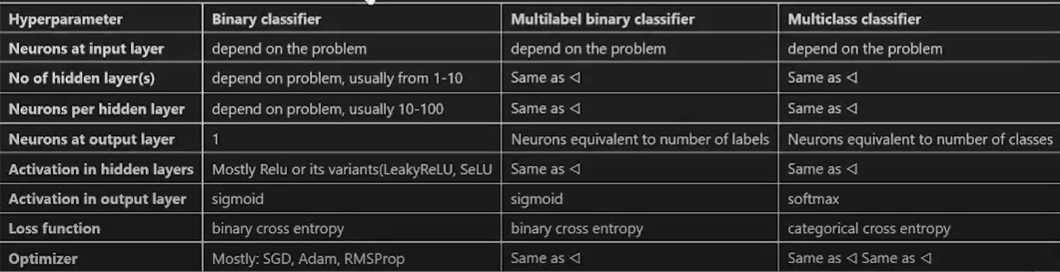

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import torchvision   #computer vision tasks in PyTorch
import torch
import torch.nn as nn    #for creating neural networks
import keras,os
import tensorflow as tf

from torch import optim
from torchvision import transforms,models,datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing import image

In [ ]:
# ==============================================================================
# Identify the device at the beginning
# ==============================================================================
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
# To avoid changing in any results --randomly
# Set the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Loading the data

In [ ]:
training_dir = '/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Training'
testing_dir = '/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Testing'
validating_dir='/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Validation'

In [ ]:
# Define the data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Load training data
train_data = train_datagen.flow_from_directory(
    training_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # For multi-class classification (7 classes)
)

Found 3087 images belonging to 7 classes.


I have normalized the images (rescale pixcel values which ranges from 0 to 1)

I do not resize the images despite the higher computational power it will take, but I need a high accuracy model (specifically because it is a healthcare solution)

In this link (https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/), it is stated that the augmentation is three different types where the second type is called in-place (on_-the-fly) data augmentation which is what Keras’ ImageDataGenerator class implements, so there is no need to augment manually



Visualize the data to check its loaded

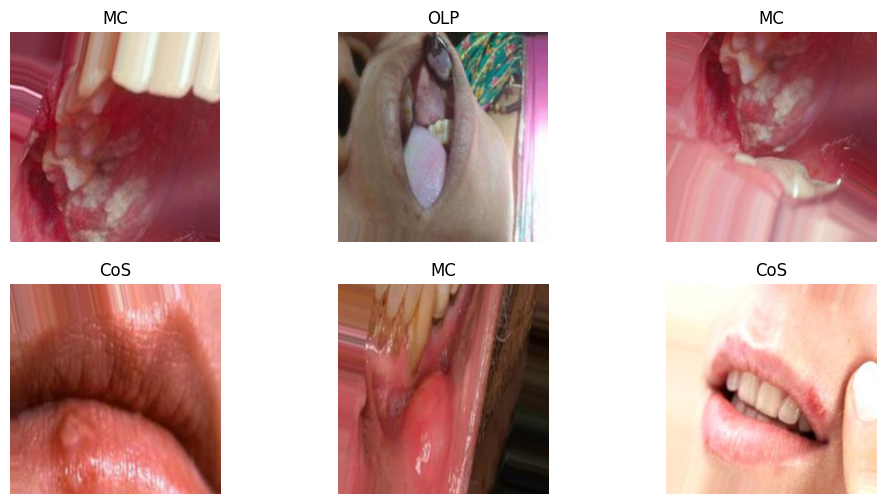

In [ ]:
# Get a batch of images and labels
images, labels = next(train_data)

# Get the class names from the class_indices dictionary
class_names = list(train_data.class_indices.keys())

# Display the images and labels
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

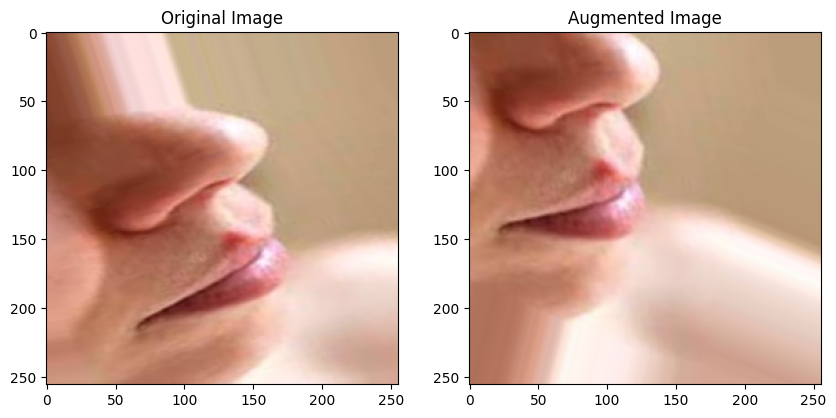

In [ ]:
# Visualizing original and augmented images
x_batch, y_batch = next(train_data)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(x_batch[0])
axes[0].set_title('Original Image')
axes[1].imshow(train_datagen.random_transform(x_batch[0])) # Use datagen instead of generator
axes[1].set_title('Augmented Image')
plt.show()

In [ ]:
# Load validating data
valid_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data = valid_data_gen.flow_from_directory(
    validating_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # For multi-class classification (7 classes)
)

Found 1028 images belonging to 7 classes.


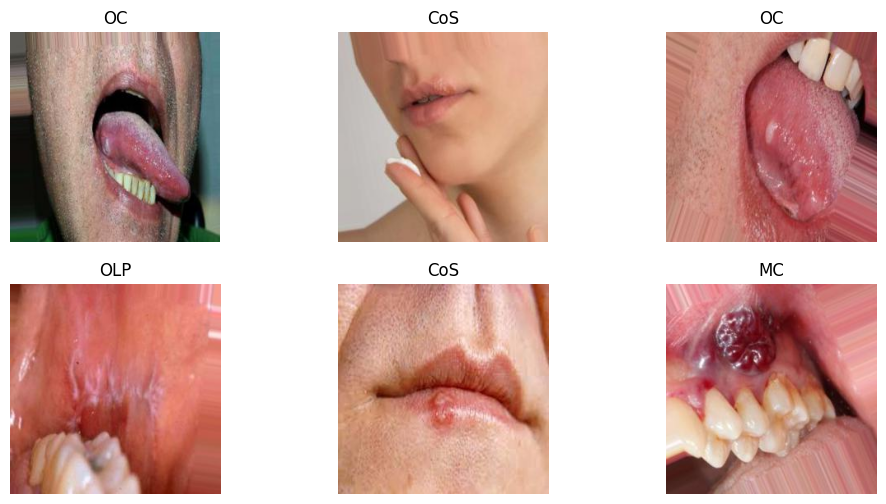

In [ ]:
# Get a batch of images and labels
images, labels = next(valid_data)

# Get the class names from the class_indices dictionary
class_names = list(valid_data.class_indices.keys())

# Display the images and labels
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

Visualization

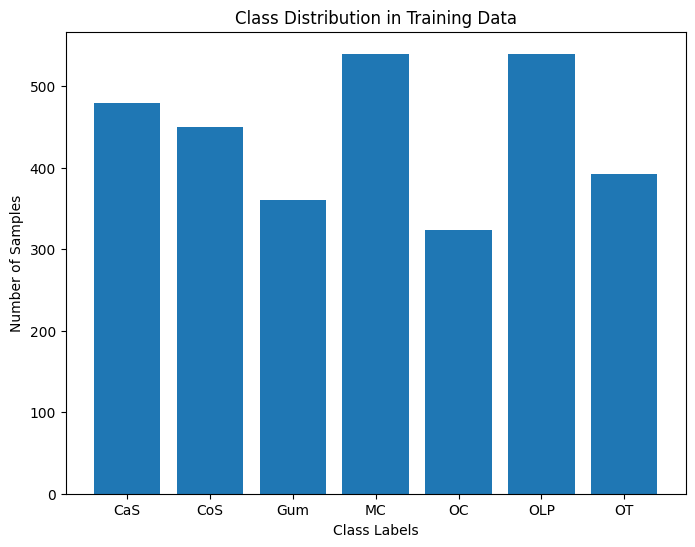

In [ ]:
# Get class labels
class_labels = list(train_data.class_indices.keys())

# Calculate the count of samples per class
class_counts = np.bincount(train_data.classes)
# train_data.classes contains samples' class labels-np.bincount used to count each class's occurrences

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.show()

I think I need to augment to add some images within specifically these classes (GUM, OC, OT) because the dataset is not balanced

We can set a weight for each class to solve the imbalance issue

In [ ]:
# Load test data
test_data_gen = ImageDataGenerator(rescale=1.0/255)
test_data = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # For multi-class classification (7 classes)
)

Found 1028 images belonging to 7 classes.


In [ ]:
n_samples = len(train_data.classes)
# Get class labels
class_labels = list(train_data.class_indices.keys())

# Calculate the count of samples per class
class_counts = np.bincount(train_data.classes)
# train_data.classes contains samples' class labels-np.bincount used to count each class's occurrences
n_classes = len(class_labels)
# Compute class weights to be used during model training
class_weights = n_samples / (n_classes * class_counts)
class_weights = {i: class_weights[i] for i in range(n_classes)}
# a list of class names corresponding to the class indices
class_names = ["Cas", "CoS", "Gum", "MC", "OC", "OLP", "OT"]

# Print class weights with class names
for i, weight in class_weights.items():
    print(f"Class {class_names[i]}: {weight:.4f}")

Class Cas: 0.9187
Class CoS: 0.9800
Class Gum: 1.2250
Class MC: 0.8167
Class OC: 1.3611
Class OLP: 0.8167
Class OT: 1.1221


I do not understand what these directories mean/represent (outputs, out,output_image) so, I deleted them

Model Building

In [ ]:
# Check if GPU is available
device = tf.device("cuda:0" if tf.test.is_gpu_available() else "cpu")

TDisease_classifier3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),  # Add batch normalization
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add batch normalization
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add batch normalization
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),  # Add batch normalization
    tf.keras.layers.Dense(7, activation='softmax')
])

# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# Custom loss function
def weighted_categorical_crossentropy(class_weights):
    class_weights = tf.convert_to_tensor(list(class_weights.values()), dtype=tf.float32)

    def loss(y_true, y_pred):
        # Compute the weighted loss for each sample
        sample_weights = tf.gather(class_weights, tf.argmax(y_true, axis=-1))
        weighted_loss = sample_weights * tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Compute the mean weighted loss
        return tf.reduce_mean(weighted_loss)

    return loss

# Specify the metric to monitor (validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Compile the model
TDisease_classifier3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                             loss=weighted_categorical_crossentropy(class_weights),
                             metrics=['accuracy'])

# The device will be automatically detected and used during training and inference

# Display model summary
TDisease_classifier3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,841,287 (56.62 MB)

 Trainable params: 14,840,583 (56.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
TDisease_classifier3.fit(train_data, epochs=100, validation_data=valid_data, c

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 736ms/step - accuracy: 0.2735 - loss: 2.1781 - val_accuracy: 0.1449 - val_loss: 3.4652
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 742ms/step - accuracy: 0.3840 - loss: 1.6382 - val_accuracy: 0.1449 - val_loss: 3.0870
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 728ms/step - accuracy: 0.4296 - loss: 1.5510 - val_accuracy: 0.1858 - val_loss: 3.1495
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 725ms/step - accuracy: 0.4748 - loss: 1.3664 - val_accuracy: 0.2218 - val_loss: 3.1898
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 74s 730ms/step - accuracy: 0.5191 - loss: 1.2479 - val_accuracy: 0.3444 - val_loss: 2.2060
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 725ms/step - accuracy: 0.5422 - loss: 1.2295 - val_accuracy: 0.4339 - val_loss: 1.4231
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 735ms/step - accuracy: 0.5399 - loss: 1.1838 - val_accuracy: 0.5652 - val_loss: 1.1102
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 736ms/step - accuracy: 0.5894 - loss: 1.0867 - 

accuracy        float64
loss            float64
val_accuracy    float64
val_loss        float64
dtype: object


<Axes: >

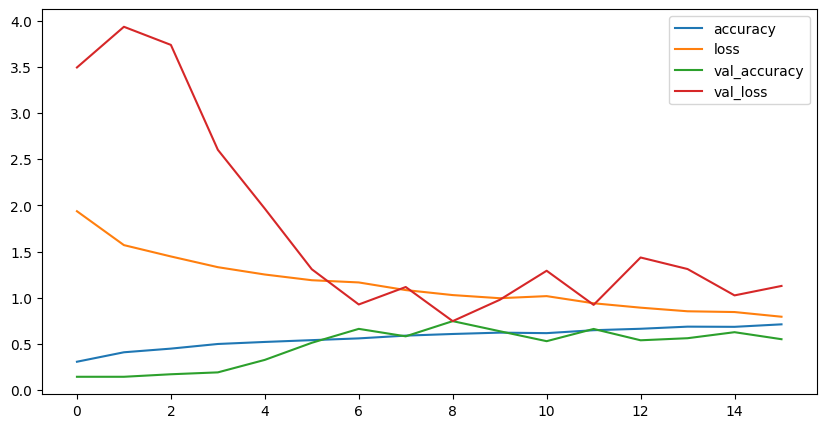

In [ ]:
# Getting the dataframe of loss and accuracies on both training and validation
loss_acc_metrics_df = pd.DataFrame(TDisease_classifier3.history.history)

# Inspect the data types of the DataFrame
print(loss_acc_metrics_df.dtypes)

# Try converting the DataFrame to numeric types
loss_acc_metrics_df = loss_acc_metrics_df.apply(pd.to_numeric, errors='coerce')

# Plotting the loss and accuracy
loss_acc_metrics_df.plot(figsize=(10,5))

In [ ]:
import tensorflow as tf

# Force eager execution to identify the issue
tf.config.run_functions_eagerly(True)

# Evaluating the model on unseen data
eval = TDisease_classifier3.evaluate(test_data)

# Printing the loss and accuracy
print("Test loss: {}\nTest accuracy: {}".format(eval[0], eval[1]))

# Deactivate eager execution (optional, depending on your needs)
tf.config.run_functions_eagerly(False)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 266s 8s/step - accuracy: 0.7103 - loss: 0.7635
Test loss: 0.7616410255432129
Test accuracy: 0.7227626442909241


Notes from the meeting:
to solve imbalance --weight for each class (before fit)
save model
draw confusion matrix
early stopping
transfer learning
gdown/request bdl m anzl w a7ml request btgebha gdown tgeb mn drive

The VGG-16 configuration typically consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. These layers are organized into blocks, with each block containing multiple convolutional layers followed by a max-pooling layer for downsampling.

Input Layer:
Input dimensions: (224, 224, 3)
Convolutional Layers (64 filters, 3×3 filters, same padding):
Two consecutive convolutional layers with 64 filters each and a filter size of 3×3.
Same padding is applied to maintain spatial dimensions.
Max Pooling Layer (2×2, stride 2):
Max-pooling layer with a pool size of 2×2 and a stride of 2.
Convolutional Layers (128 filters, 3×3 filters, same padding):
Two consecutive convolutional layers with 128 filters each and a filter size of 3×3.
Max Pooling Layer (2×2, stride 2):
Max-pooling layer with a pool size of 2×2 and a stride of 2.
Convolutional Layers (256 filters, 3×3 filters, same padding):
Two consecutive convolutional layers with 256 filters each and a filter size of 3×3.
Convolutional Layers (512 filters, 3×3 filters, same padding):
Two sets of three consecutive convolutional layers with 512 filters each and a filter size of 3×3.
Max Pooling Layer (2×2, stride 2):
Max-pooling layer with a pool size of 2×2 and a stride of 2.
Stack of Convolutional Layers and Max Pooling:
Two additional convolutional layers after the previous stack.
Filter size: 3×3.
Flattening:
Flatten the output feature map (7x7x512) into a vector of size 25088.
Fully Connected Layers:
Three fully connected layers with ReLU activation.
First layer with input size 25088 and output size 4096.
Second layer with input size 4096 and output size 4096.
Third layer with input size 4096 and output size 1000, corresponding to the 1000 classes in the ILSVRC challenge.
Softmax activation is applied to the output of the third fully connected layer for classification.

https://www.geeksforgeeks.org/vgg-16-cnn-model/

Further advancements: Resnets are introduced to prevent exploding gradients problem that occurred in VGG-16.

Using https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c to code

In [ ]:
# Set up the data generators
trdata = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values
traindata = trdata.flow_from_directory(training_dir,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='categorical')

valid_data = ImageDataGenerator(rescale=1.0/255)
valdata = valid_data.flow_from_directory(validating_dir,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical')

tsdata = ImageDataGenerator(rescale=1.0/255)
testdata = tsdata.flow_from_directory(testing_dir,
                                       target_size=(224, 224),
                                       batch_size=32,
                                       class_mode='categorical')

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=7, activation="softmax"))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,289,223 (512.27 MB)

 Trainable params: 134,289,223 (512.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint("best_model.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max')

In [ ]:
hist = model.fit(traindata,
                 validation_data=valdata,
                 epochs=100,
                 callbacks=[checkpoint, early])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1564 - loss: 2.2395 
Epoch 1: val_accuracy improved from -inf to 0.17510, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1523s 14s/step - accuracy: 0.1565 - loss: 2.2371 - val_accuracy: 0.1751 - val_loss: 1.9303
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.1707 - loss: 1.9312
Epoch 2: val_accuracy did not improve from 0.17510
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 575ms/step - accuracy: 0.1707 - loss: 1.9312 - val_accuracy: 0.1751 - val_loss: 1.9298
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.1719 - loss: 1.9362
Epoch 3: val_accuracy did not improve from 0.17510
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 569ms/step - accuracy: 0.1719 - loss: 1.9362 - val_accuracy: 0.1751 - val_loss: 1.9301
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.1828 - loss: 1.9327
Epoch 4: val_accuracy did not improve from 0.17510
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 518ms/step - accuracy: 0.1827 - loss: 1.9

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testdata)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 359s 11s/step - accuracy: 0.1790 - loss: 1.9278
Test Loss: 1.9298
Test Accuracy: 0.1751


https://github.com/vaibhavcodes/DeepLearning-Architectures/blob/master/04_VGG-16%20Transfer%20Learning.ipynb

In [ ]:
# The entire network is present under VGG16 feature extractor
from keras.applications.vgg16 import VGG16
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape= (224,224,3))

# include_top: Whether to include the 3 fully-connected layers at the top of the network.

# weights: 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

# input_shape: optional shape tuple, only to be specified if include_top is False
#             (otherwise the input shape has to be (224, 224, 3) (with channels_last data format)
#             or (3, 224, 224) (with channels_first data format).
# NOTE: It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Summary of the model
model_vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Preventing the 13 Convolution layers to be trained
model_vgg.trainable = False

In [ ]:
# Checking the layers present in our model
model_vgg.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [ ]:
# Model Creation
# Define input shape
input_shape = (224, 224, 3)

# Create a new input layer
input_tensor = keras.Input(shape=input_shape)

# Pass the input tensor to model_vgg
output_vgg = model_vgg(input_tensor)

# Add GlobalAveragePooling2D layer
x = keras.layers.GlobalAveragePooling2D()(output_vgg)

# Add the dense layers
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output_tensor = Dense(7, activation='sigmoid')(x)

# Create the model
model3 = keras.Model(inputs=input_tensor, outputs=output_tensor)

# Getting the structure of our model
model3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       2,101,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │          28,679 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,625,927 (128.27 MB)

 Trainable params: 18,911,239 (72.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compiling the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fitting the model
result = model3.fit(traindata, steps_per_epoch=100, verbose=1, validation_data=valdata, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 97/100 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.2745 - loss: 2.1715

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1389s 13s/step - accuracy: 0.2776 - loss: 2.1569 - val_accuracy: 0.4981 - val_loss: 1.3608
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.5291 - loss: 1.2430 - val_accuracy: 0.5739 - val_loss: 1.1147
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.6098 - loss: 0.9953 - val_accuracy: 0.6809 - val_loss: 0.8717
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.7075 - loss: 0.7925 - val_accuracy: 0.7286 - val_loss: 0.7373
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.7478 - loss: 0.6585 - val_accuracy: 0.7510 - val_loss: 0.6877
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.7912 - loss: 0.5767 - val_accuracy: 0.7510 - val_loss: 0.6740
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.8130 - loss: 0.5102 - val_accuracy: 0.7792 - val_loss: 0.6512
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.8518 - loss: 0.4073 - val

In [ ]:
# Save the model
model3.save('vgg16.h5')

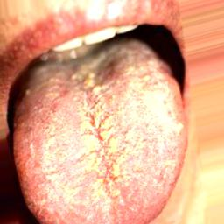

In [ ]:
# Load the testing image
test_img = image.load_img(r"/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Testing/OLP/p_1292_0_9759.jpg", target_size=(224,224))
test_img

In [ ]:
# Converting image to array
test_img = np.asarray(test_img)
test_img.shape

(224, 224, 3)

In [ ]:
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 224, 224, 3)

In [ ]:
# Loading the model
saved_model = load_model('vgg16.h5')

In [ ]:
# Predicting from the saved model
output = saved_model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Class names
class_names = ["Cas", "CoS", "Gum", "MC", "OC", "OLP", "OT"]

# Get the index of the class with the highest probability
predicted_class_index = output.argmax(axis=1)[0]

# Print the corresponding class name
print(class_names[predicted_class_index])

Gum


In [ ]:
# test
model3.evaluate(testdata)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 357s 11s/step - accuracy: 0.9370 - loss: 0.2458


[0.25336799025535583, 0.9396887421607971]

In [1]:
! pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00


In [2]:
!wget -q -O - ipv4.icanhazip.com

34.74.50.89


In [6]:
!npm install -g localtunnel@2.0.2 -y


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [8]:
!npm i --package-lock-only

npm ERR! code ENOENT
npm ERR! syscall open
npm ERR! path /content/package.json
npm ERR! errno -2
npm ERR! enoent ENOENT: no such file or directory, open '/content/package.json'
npm ERR! enoent This is related to npm not being able to find a file.
npm ERR! enoent 

npm ERR! A complete log of this run can be found in:
npm ERR!     /root/.npm/_logs/2024-08-30T16_08_53_310Z-debug-0.log


In [9]:
!npm audit fix --force

npm WARN using --force Recommended protections disabled.

up to date, audited 1 package in 225ms

found 0 vulnerabilities


In [ ]:
! streamlit run App.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.74.50.89:8501

your url is: https://blue-lemons-yell.loca.lt
2024-08-30 16:09:58.669844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 16:09:58.693157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 16:09:58.700324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 16:09:58.718610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instruc